In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/datasets/face_images.zip"

Libraries

In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [3]:
IMG_SIZE = (128, 128)
IMG_PATH = "/content/face_images"
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

Reading Dataset

In [4]:
# Reading dataset and splitting into train set and validation set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    validation_split=0.2,
    subset="training",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=21
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    validation_split=0.2,
    subset="validation",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=21
)

Found 22801 files belonging to 2 classes.
Using 18241 files for training.
Found 22801 files belonging to 2 classes.
Using 4560 files for validation.


In [5]:
classes = train_ds.class_names
print(classes)

['female', 'male']


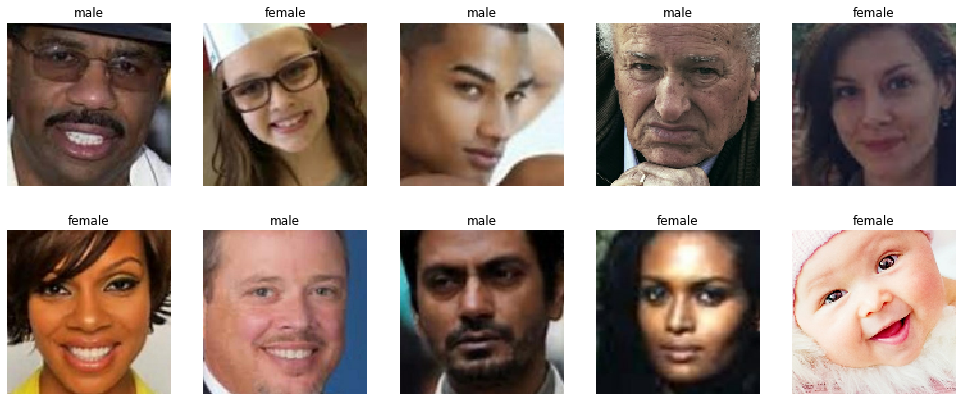

In [6]:
# Display some images
plt.figure(figsize=(17, 7))
for images, labels in train_ds.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), interpolation="nearest")
        plt.title(classes[labels[i]])
        plt.axis("off")

In [36]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

ANN

In [37]:
def get_classifier():
    input_layer = layers.Input(shape=(*IMG_SIZE, 3))
    
    layer = layers.experimental.preprocessing.Rescaling(1. / 255)(input_layer)
    layer = layers.Conv2D(128, 3, activation="relu", kernel_initializer="he_uniform")(layer)
    layer = layers.AvgPool2D((2, 2))(layer)
    layer = layers.Conv2D(64, 3, activation="relu", kernel_initializer="he_uniform")(layer)
    layer = layers.AvgPool2D((2, 2))(layer)
    layer = layers.Conv2D(32, 3, activation="linear", kernel_initializer="he_uniform")(layer)
    layer = layers.AvgPool2D((2, 2))(layer)
    layer = layers.Flatten()(layer)

    layer = layers.Dense(128, activation="relu")(layer)
    layer = layers.Dense(64, activation="relu")(layer)
    layer = layers.Dense(32, activation="relu")(layer)
    layer = layers.Dense(1, activation="sigmoid")(layer)
    
    classifier = tf.keras.models.Model(inputs=input_layer, outputs=layer)
    
    classifier.compile(
        optimizer=tf.optimizers.Adam(learning_rate=1e-4),
        loss=tf.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )
    
    return classifier

classifier = get_classifier()

In [38]:
classifier.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 126, 126, 128)     3584      
_________________________________________________________________
average_pooling2d_13 (Averag (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        73792     
_________________________________________________________________
average_pooling2d_14 (Averag (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        1846

Training

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    mode="min", 
    monitor="val_loss", 
    patience=2,
    restore_best_weights=True
)

classifier_history = classifier.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=early_stopping
)

Epoch 1/50
1141/1141 [==============================] - 48s 41ms/step - loss: 0.5380 - accuracy: 0.7272 - val_loss: 0.4540 - val_accuracy: 0.7820
Epoch 2/50
1141/1141 [==============================] - 47s 41ms/step - loss: 0.4319 - accuracy: 0.7967 - val_loss: 0.4058 - val_accuracy: 0.8064
Epoch 3/50
1141/1141 [==============================] - 47s 41ms/step - loss: 0.3842 - accuracy: 0.8240 - val_loss: 0.3854 - val_accuracy: 0.8239
Epoch 4/50
1141/1141 [==============================] - 47s 41ms/step - loss: 0.3436 - accuracy: 0.8483 - val_loss: 0.3732 - val_accuracy: 0.8311
Epoch 5/50
1141/1141 [==============================] - 47s 41ms/step - loss: 0.3012 - accuracy: 0.8706 - val_loss: 0.3732 - val_accuracy: 0.8344
Epoch 6/50
1141/1141 [==============================] - 47s 41ms/step - loss: 0.2590 - accuracy: 0.8916 - val_loss: 0.3723 - val_accuracy: 0.8382
Epoch 7/50
1141/1141 [==============================] - 47s 41ms/step - loss: 0.2222 - accuracy: 0.9094 - val_loss: 0.3979 -

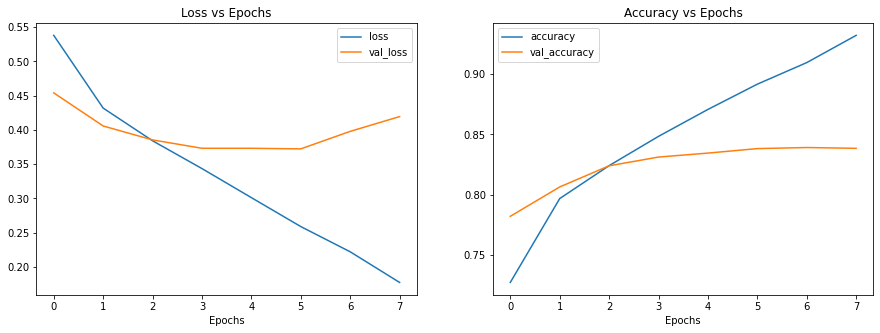

In [40]:
plt.figure(figsize=(15, 5))

# Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(classifier_history.history.get("loss"))
plt.plot(classifier_history.history.get("val_loss"))
plt.xticks(range(len(classifier_history.history.get("loss"))))
plt.legend(["loss", "val_loss"])
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")

# Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(classifier_history.history.get("accuracy"))
plt.plot(classifier_history.history.get("val_accuracy"))
plt.xticks(range(len(classifier_history.history.get("accuracy"))))
plt.legend(["accuracy", "val_accuracy"])
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")

plt.show()

Evaluation

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

y_true = np.concatenate([y for _, y in valid_ds], axis=0)
y_pred = classifier.predict(valid_ds).ravel()

accuracy_list = []

# Thresholds
tpr, fpr, threshold = roc_curve(y_true, y_pred)

# Accuracy score based on different threshold
for thresh in threshold:
    thresh_y_pred = np.where(y_pred > thresh, 1, 0)
    accuracy_list.append((thresh, accuracy_score(y_true, thresh_y_pred)))
    
accuracy_list = pd.DataFrame(accuracy_list, columns=["threshold", "accuracy"], index=None)
accuracy_list.sort_values(by="accuracy", ascending=False, inplace=True)

# Thresholds with highest accuracy
best_threshold = accuracy_list.threshold.iloc[0]
accuracy_list.head()

,threshold,accuracy
569,0.538446,0.840570
558,0.549802,0.840570
570,0.537052,0.840351
568,0.538804,0.840351
563,0.546081,0.840351


In [42]:
print("Accuracy Score: 0.5 threshold")
print(accuracy_score(y_true, np.where(y_pred > 0.5, 1, 0)))

print(f"\nAccuracy Score: {best_threshold} threshold")
print(accuracy_score(y_true, np.where(y_pred > best_threshold, 1, 0)))

Accuracy Score: 0.5 threshold
0.8381578947368421

Accuracy Score: 0.5384455919265747 threshold
0.8405701754385965


Predicting

In [15]:
import dlib
import requests

face_detecter = dlib.get_frontal_face_detector()
def detect_face(image: np.ndarray):
    expand = 30
    rects = face_detecter(image, 1)
    for i, rect in enumerate(rects[:1]):
        face_image = image[rect.top() - expand : rect.bottom() + expand, rect.left() - expand : rect.right() + expand]
        face_image = cv2.resize(face_image, (IMG_SIZE))
        return face_image
    return None

def get_random_google_images():
    # Unsplash urls
    urls = [
        "https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1494790108377-be9c29b29330?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1557296387-5358ad7997bb?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=788&q=80",
        "https://images.unsplash.com/photo-1493106819501-66d381c466f1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1577975819014-2d6f1e721e77?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1100&q=80",
        "https://images.unsplash.com/photo-1603775020644-eb8decd79994?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1509868918748-a554ad25f858?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1618716060974-98b20e2395cd?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=800&q=80",
        "https://images.unsplash.com/photo-1521227889351-bf6f5b2e4e37?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1250&q=80",
        "https://images.unsplash.com/photo-1611796154177-a10865bd9f62?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1585079225993-9f05a74f1d70?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1650&q=80",
        "https://images.unsplash.com/photo-1622109133861-5555bd667254?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=648&q=80",
        "https://images.unsplash.com/photo-1593757147298-e064ed1419e5?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1492462543947-040389c4a66c?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1650&q=80",
        "https://images.unsplash.com/photo-1506956191951-7a88da4435e5?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1334&q=80",
        "https://images.unsplash.com/photo-1523824921871-d6f1a15151f1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1492106087820-71f1a00d2b11?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1487222477894-8943e31ef7b2?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=852&q=80",
    ]
    images, face_images = [], []
    
    for url in urls:
        try:
            response = requests.get(url)
            
            if response.status_code == 200:
                # Downloading image
                image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
                # Detecting face using dlib
                face_img = detect_face(image)
                
                images.append(image)
                face_images.append(face_img)
        except Exception as error:
            print(error)
            continue
    return images, face_images

scraped_images, scraped_face_images = get_random_google_images()

print("Images Scraped:", len(scraped_images))

Images Scraped: 18


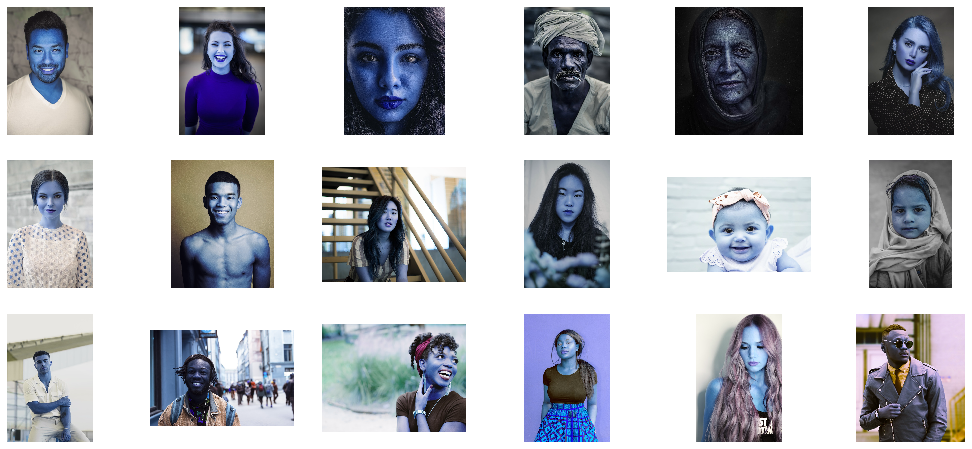

In [43]:
# Printing Scraped images
plt.figure(figsize=(18, 8))
for i in range(len(scraped_images)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(scraped_images[i], interpolation="nearest")
    plt.axis("off")
plt.show()

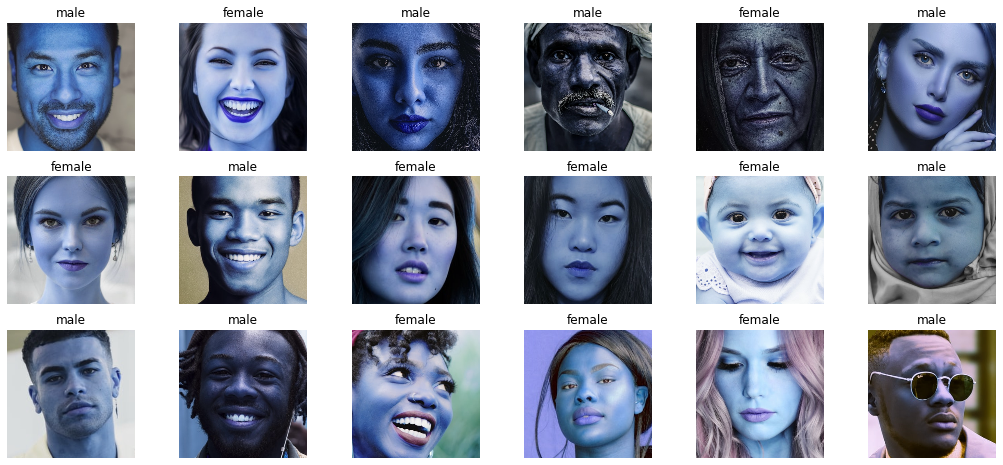

In [44]:
# Prediction on face images
classifier_prediction = classifier.predict(np.array(scraped_face_images))
classifier_prediction = np.where(classifier_prediction > best_threshold, 1, 0).ravel()

plt.figure(figsize=(18, 8))
for i in range(len(scraped_images)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(scraped_face_images[i], interpolation="nearest")
    plt.axis("off")
    plt.title(classes[classifier_prediction[i]])
plt.show()